# Simple data analysis with Apache Spark
In this example we are going to use Apache Spark to perform distributed analysis on a CSV generated by our Python scrapping class. The goal of this program is mainly to clean data for further analysis down the line.


In [2]:
# Do an initial test of Spark to make sure it works.
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext('local[*]')
# do something to prove it works
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)
sc.stop()

Now that we have checked that PySpark is up and running let's start to do some processing using a csv file generated previously using fb_post.py (for instructions on using fb_scrapper please see the readme file). First we are going to read the CSV file into a data frame and filter out stop words and punctation.

In [53]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import regexp_replace, trim, col, lower 
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
#Comment and uncomment the following line as necessary
#sc = pyspark.SparkContext('local[*]')
sqlContext = SQLContext(sc)
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('160558090672531_facebook_statuses.csv')
df.show()
# Drop the null crap 
df = df.na.drop(subset=["status_message"])
# Remove punctation from status messages
df2 = df.select(regexp_replace("status_message", "\p{Punct}", "").alias("status_message"), "status_id")
df2.show()
messages = df2
# Tokenize and remove stop words
tokenizer = Tokenizer(inputCol="status_message", outputCol="filtered")
filterw = tokenizer.transform(messages)
filterw.show()
remover = StopWordsRemover(inputCol="filtered", outputCol="filtered1")
filtered_final = remover.transform(filterw)
filtered_final.show()
messages = filtered_final.select("filtered1")
messages2 = filtered_final.select("status_id","status_message").rdd
# We will use this to create our inverted index later in the file
doc_index = messages2.collectAsMap()
#Convert to RDD
message_rdd=messages.rdd


+--------------------+--------------------+----------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|           status_id|      status_message| link_name|status_type|         status_link|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+--------------------+--------------------+----------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|160558090672531_1...|So, rain is in th...|      null|     status|                null|2016-12-22 13:34:30|            4|          15|         0|        4|        0|       0|        0|       0|         0|
|160558090672531_1...|                null|      null|     status|                null|2016-12-22 21:38:02|           15|           3|         0|       14|        0|       1|      

Now we are going to do a simple word count with the rdd that we just created and generate a graph of the top words.


The top words are:
boat: 169
anyone: 144
one: 116
get: 93
canoe: 91
im: 91
like: 87
ocoee: 82


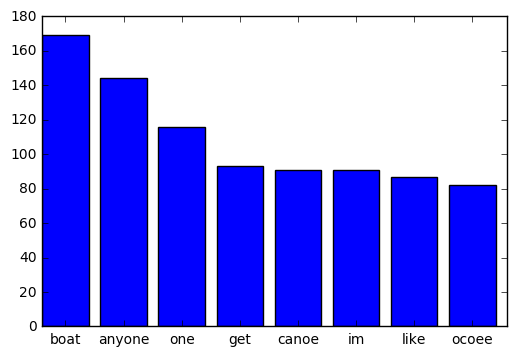

In [54]:
# WordCount with RDD. Normally this would be used in conjunction with NLP to extract trending topics.
from operator import add
import matplotlib.pyplot as plt
import numpy as np
def plot_histogram(indexes, values):
    indexes2 = np.arange(len(indexes))
    values = np.asarray(values)
    plt.bar(indexes2, values)
    bar_width = 2
    plt.xticks(indexes2 + bar_width*.2, indexes)
    plt.show()
# Prints the WordCount of words that appear more than 25 times and appends them to indexes and values.
def print_word_count(output, indexes, values):
    for (word, count) in output:
        if count > 25 and word is not "":
            # append to indexes
            indexes.append(word)
            values.append(count)
            print("%s: %i" % (word, count))
    
    

statuses = message_rdd.flatMap(lambda x: x)
words = statuses.flatMap(lambda x: x)
#se = statuses.flatMap(String)
counts = words.flatMap(lambda x: x.split(' ')) \
                  .map(lambda x: (x, 1)) \
                  .reduceByKey(add)               


output1 = counts.sortByKey().collectAsMap()
wordsMap = counts.collectAsMap()
#ouput1.saveAsTextFile("keys.txt")
# Get just the most popular words 
output = counts.takeOrdered(9, key = lambda x: -x[1])
indexes = []
values = []
print("The top words are:")
print_word_count(output, indexes, values)
plot_histogram(indexes,values)

### Create a document index and an inverted index
Now that we have done some simple procesing lets get into the meat of this notebook. We are going to create an inverted index using MR.

In [55]:
def make_document_index(raw_status):
    status = raw_status.flatMap(lambda x : x)
    doc_index = status.zipWithIndex()
    doc_index = doc_index.map(lambda y: (y[1], y[0])).collectAsMap()
    return doc_index
def inverted_index(documents):
    #Invert to (status_id, terms[]) and then flatMapValues in order to get (status_id, term)
    documents = documents.map(lambda x: (x[1],x[0])).flatMapValues(lambda x: x)
    #Undo to (term, status_id) and reduce to get (term, status_ids[])
    documents = documents.map(lambda x: (x[1],[x[0]])).reduceByKey(lambda a,b: a+b)
    print("inverted index sucessfully created")
    return documents 
messages = filtered_final.select("filtered1","status_id").rdd
status_inverted_index = inverted_index(messages)
inverted_map = status_inverted_index.collectAsMap() 

inverted index sucessfully created


In [44]:
# Load file
def get_word_count(some_dict, aRDD):
    return aRDD.filter(lambda x: x in list(some_dict.keys())).map(lambda key: (key, some_dict[key]))
names = sc.textFile("rivers.txt")
riverNames = names.flatMap(lambda x: x.split("\n"))
r = get_word_count(wordsMap, riverNames)
#r = riverNames.filter(lambda x : x in list(wordsMap.keys())).map(lambda key: (key, wordsMap[key]))
r.collect()

[('tellico', 24), ('ocoee', 82)]

We will now be doing some interactive analysis with iPython widgets. (Note this will not necessarily render in GitHub, but if you download the notebook you should be able to see it).

In [45]:
# Let's try to make things a little more interactive
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
value_search = widgets.Text() 
display(value_search)
value_search2 = widgets.Text() 
display(value_search2)

def find_key(sender):
    text = value_search.value
    if text in output1: 
        print(text + " occurs " + str(output1[text]) + " times in the file")
# Todo clean up sloppy method
def mini_search(sender):
    text = value_search2.value.strip(" ")
    if text in inverted_map:
        l = inverted_map[text]
        for i in l:
            if i in doc_index:
                l = i 
                print(doc_index[i])
value_search.on_submit(find_key)
value_search2.on_submit(mini_search)



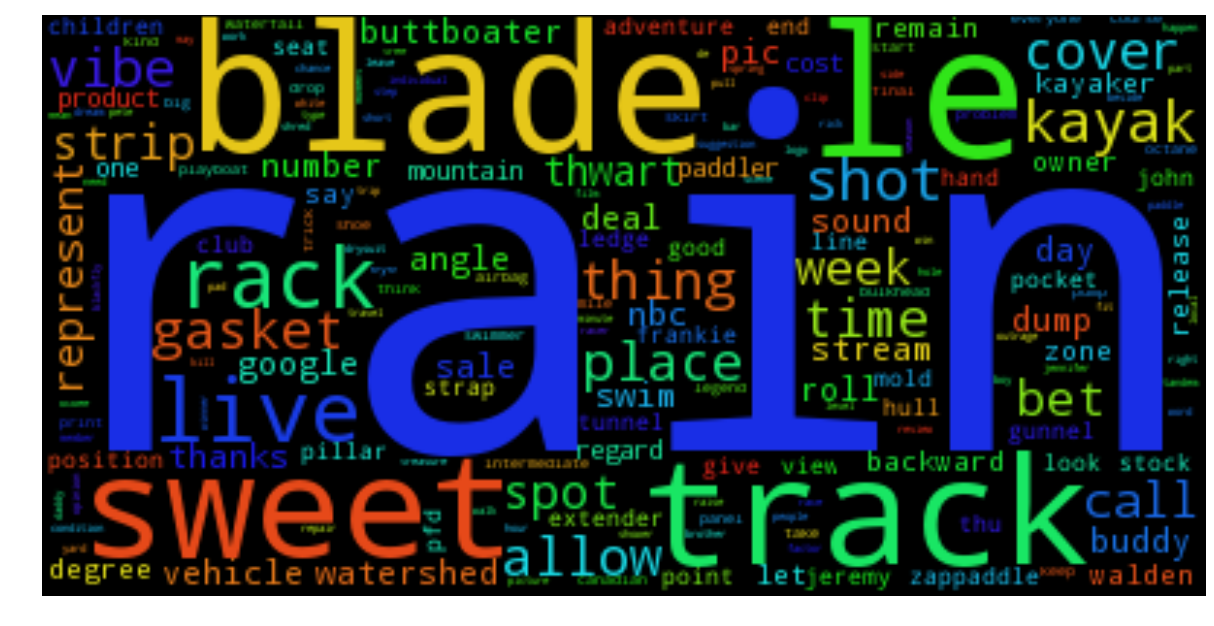

In [47]:
#Wordcloud example 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
def makeWordCloud(words):
    stopwords = set(STOPWORDS)
    stopwords.add("thank")
    wordcloud = WordCloud(stopwords=stopwords, background_color='black').generate(" ".join(wordlist))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
wordlist = output1.keys()
makeWordCloud(words)


In [48]:
# Filter to extract known names of rivers and get useful URLS 
df2 = df.na.drop(subset=["status_link"])
df3 = df2.select("status_link")
df2.show()

+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|           status_id|      status_message|           link_name|status_type|         status_link|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|160558090672531_1...|              Zoomie|                null|      video|https://www.faceb...|2016-12-21 19:12:13|           55|          13|         4|       50|        0|       5|        0|       0|         0|
|160558090672531_1...|Someone don't see...|                null|      video|https://www.faceb...|2016-12-21 17:40:37|           34|         

Okay so now we want to get the images and or videos. Uses for the images might include image search for our database (with the river extracted using NLP) or computer vision applications. 

In [49]:
#Now let's try to use these urls to get their the respective images or videos 
from pyspark.sql import SparkSession
from lxml import html
import requests
from IPython.display import Image
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
df2.createOrReplaceTempView("posts")
sqlDF = spark.sql("SELECT * FROM posts WHERE status_link LIKE '%photo%'")
sqlDF.show()
statusRDD = sqlDF.select('status_link').rdd
urls = statusRDD.flatMap(lambda x: x)
print(urls.take(3))
#Now let's save the images possibly for a Computer Vision application
urls2 = urls.collect()

#for url in urls2:
    #page = requests.get(url)
    #tree = html.fromstring(page.content)
    #imageUrl = tree.xpath('//img[@class="spotlight"]/@src')

+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|           status_id|      status_message|           link_name|status_type|         status_link|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|160558090672531_1...|Doopey, Mr. Magoo...|                null|      photo|https://www.faceb...|2016-12-21 18:35:29|            9|           0|         0|        9|        0|       0|        0|       0|         0|
|160558090672531_1...|we needed more sa...|                null|      photo|https://www.faceb...|2016-12-21 18:25:58|           11|         

## Latent Dirichlet allocation

In [7]:
# This section remains buggy and prone to jams run at your own risk!
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.feature import IDF
from pyspark.ml.feature import CountVectorizer
from pyspark.mllib.linalg import Vectors
#vectorize tags array for each user
vectorizer = CountVectorizer(inputCol="filtered1", outputCol="features").fit(filtered_final)
countVectors = vectorizer.transform(filtered_final).select("status_id", "features")
countVectors.show()
#find TF-IDF coefficients for each tag
print("begin")
frequencyVectors = countVectors.rdd.map(lambda vector: vector[1])
frequencyDenseVectors = frequencyVectors.map(lambda vector: Vectors.dense(vector))
idf = IDF().fit(frequencyDenseVectors)
print('fitting complete')
tfidf = idf.transform(frequencyDenseVectors)
print("tf idf complete")
#prepare corpus for LDA
corpus = tfidf.map(lambda x: [1, x]).cache()
print("entering lda phase")
#train LDA
ldaModel = LDA.train(corpus, k = 15, maxIterations=100, optimizer="online", docConcentration=2.0, topicConcentration=3.0)
print("lda model complete")


+--------------------+--------------------+
|           status_id|            features|
+--------------------+--------------------+
|160558090672531_1...|(4709,[2,4,7,9,14...|
|160558090672531_1...| (4709,[3791],[1.0])|
|160558090672531_1...|(4709,[20,25,43,4...|
|160558090672531_1...|(4709,[3,9,12,28,...|
|160558090672531_1...|(4709,[2,92,154,2...|
|160558090672531_1...| (4709,[4704],[1.0])|
|160558090672531_1...|(4709,[530,2881],...|
|160558090672531_1...|(4709,[521,527,15...|
|160558090672531_1...|(4709,[253,260],[...|
|160558090672531_1...|(4709,[514,764],[...|
|160558090672531_1...|(4709,[381,514],[...|
|160558090672531_1...|(4709,[7,129,170,...|
|160558090672531_1...|(4709,[527,763,12...|
|160558090672531_1...|(4709,[253,742,10...|
|160558090672531_1...|(4709,[0,6,10,24,...|
|160558090672531_1...|(4709,[0,36,104,1...|
|160558090672531_1...| (4709,[3983],[1.0])|
|160558090672531_1...| (4709,[3926],[1.0])|
|160558090672531_1...|(4709,[1,3,26,69,...|
|160558090672531_1...|(4709,[30,

In [36]:
#ldaModel.save(sc, "ldaModel")
from operator import itemgetter
topics = ldaModel.topicsMatrix()
#for topic in range(3):
    #print("Topic " + str(topic) + ":")
    #for word in range(0, ldaModel.vocabSize()):
        #print(" " + str(topics[word][topic]))
# Now lets get the words back
topicIndices = ldaModel.describeTopics(maxTermsPerTopic=5)
vocablist = vectorizer.vocabulary
topicsRDD = sc.parallelize(topicIndices)
termsRDD = topicsRDD.map(lambda topic: (zip(itemgetter(*topic[0])(vocablist), topic[1])))

indexedTermsRDD = termsRDD.zipWithIndex()
termsRDD = indexedTermsRDD.flatMap(lambda term: [(t[0], t[1], term[1]) for t in term[0]])
termDF = termsRDD.toDF(['term', 'probability', 'topicId'])
termDF.orderBy('topicID').show()



+----------+--------------------+-------+
|      term|         probability|topicId|
+----------+--------------------+-------+
|          |0.002115260722177052|      0|
|outfitting|0.002082394032980986|      0|
| condition|0.002233789998397361|      0|
|      sale|0.001751120910836...|      0|
|      bags|  0.0039045116955342|      0|
|      left|0.002958445989501369|      1|
|       dry|0.003085064387193...|      1|
|     right|0.006624683678297395|      1|
|      bank|0.003388931845333321|      1|
|      said|0.003386598220352003|      1|
|        xl|8.867720745763356E-4|      2|
|     kinda|9.783993162960018E-4|      2|
|       dad|0.001508739022845...|      2|
|      yall|0.001684071699308...|      2|
|       got|0.001003047322064...|      2|
|      made|0.001074434286731...|      3|
|      rich|0.001250121524622...|      3|
|     video|0.004485848624344074|      3|
|     moore|0.001177269382172...|      3|
|         8|0.001054212003362...|      3|
+----------+--------------------+-

In [42]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
t2 = termDF

t2.createOrReplaceTempView("topics")

terms=spark.sql("SELECT * FROM topics WHERE probability>.0001")
terms.show()


+----------+--------------------+-------+
|      term|         probability|topicId|
+----------+--------------------+-------+
|      bags|  0.0039045116955342|      0|
| condition|0.002233789998397361|      0|
|          |0.002115260722177052|      0|
|outfitting|0.002082394032980986|      0|
|      sale|0.001751120910836...|      0|
|     right|0.006624683678297395|      1|
|      bank|0.003388931845333321|      1|
|      said|0.003386598220352003|      1|
|       dry|0.003085064387193...|      1|
|      left|0.002958445989501369|      1|
|      yall|0.001684071699308...|      2|
|       dad|0.001508739022845...|      2|
|       got|0.001003047322064...|      2|
|     kinda|9.783993162960018E-4|      2|
|        xl|8.867720745763356E-4|      2|
|     video|0.004485848624344074|      3|
|      rich|0.001250121524622...|      3|
|     moore|0.001177269382172...|      3|
|      made|0.001074434286731...|      3|
|         8|0.001054212003362...|      3|
+----------+--------------------+-

In [ ]:
import pyLDAvis
import pyLDAvis.graphlab
import graphlab as gl
pyLDAvis.prepare(ldaModel.topicsMatrix(),vocabList,)

In [50]:
# More Natural Language Processing using NLP. Lemmatization, Chunking, and Tagging. 
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
messages = filtered_final.select("filtered")
message_rdd=messages.rdd
message_rdd = message_rdd.flatMap(lambda x:x)
print(message_rdd.first())
pos_statuses = message_rdd.map(nltk.pos_tag)
print(pos_statuses.take(5))
# To do get lemmatization working

['so', 'rain', 'is', 'in', 'the', 'forecast', 'for', 'saturday', 'and', 'saturday', 'night', 'which', 'means', 'we', 'may', 'get', 'some', 'natural', 'flow', 'for', 'christmas', 'would', 'anyone', 'be', 'down', 'to', 'paddle', 'if', 'that', 'happens', 'like', 'little', 'or', 'tellico', 'or', 'something', 'rich', 'holly', 'alex', 'aaaaaaanyone']
[[('so', 'RB'), ('rain', 'NN'), ('is', 'VBZ'), ('in', 'IN'), ('the', 'DT'), ('forecast', 'NN'), ('for', 'IN'), ('saturday', 'JJ'), ('and', 'CC'), ('saturday', 'JJ'), ('night', 'NN'), ('which', 'WDT'), ('means', 'VBZ'), ('we', 'PRP'), ('may', 'MD'), ('get', 'VB'), ('some', 'DT'), ('natural', 'JJ'), ('flow', 'NN'), ('for', 'IN'), ('christmas', 'NN'), ('would', 'MD'), ('anyone', 'NN'), ('be', 'VB'), ('down', 'VBN'), ('to', 'TO'), ('paddle', 'VB'), ('if', 'IN'), ('that', 'DT'), ('happens', 'VBZ'), ('like', 'JJ'), ('little', 'JJ'), ('or', 'CC'), ('tellico', 'NN'), ('or', 'CC'), ('something', 'NN'), ('rich', 'JJ'), ('holly', 'RB'), ('alex', 'VBP'), ('